<a href="https://colab.research.google.com/github/Data-Intelligence-Mastery/project-fault-segmentation/blob/master/01_fault_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculate fault metrics, including strike and dip of a fault, max length, area.

## 1. Strike and dip 
Here I will show how to calculate the strike and dip of fault using two different methods

Let's load the fault surface points data. Each surface point has (x,y,z) coordinates.

First, let's organize the fault data. Store the coordinates of each fault into a dictionary with the fault ID, `Fault` as the keys. There are total 352 faults.

In [10]:
# Import and read data

import pandas as pd

path = 'https://raw.githubusercontent.com/Data-Intelligence-Mastery/project-fault-segmentation/master/data/fault_surfaces_points.csv'
fsp = pd.read_csv(path)
fsp.rename(columns={'Unnamed: 0': 'Row_NO'}, inplace=True) # Rename the Unnamed column

# Organize data
# Create a dictionary with Fault # as the dictionary key
import numpy as np
from tabulate import tabulate

fsp_uni = fsp.Fault.unique()

fsp_dict = dict()
for i in fsp_uni:
  fsp_dict[i] = fsp.loc[fsp['Fault']==i]
  temp = fsp_dict[i].copy()
  new_index = pd.DataFrame(temp.index)
  temp.loc[:,'Row_NO'] = range(len(temp)) # Reset the Row_NO to the number of rows for that single fault
  fsp_dict[i] = temp

print(tabulate(fsp_dict[0].iloc[0:6,:], headers='keys',tablefmt='psql'))

+----+----------+---------+----------+----------+----------+
|    |   Row_NO |   Fault |        X |        Y |        Z |
|----+----------+---------+----------+----------+----------|
|  0 |        0 |       0 | -5445    | -2207    | -2189.91 |
|  1 |        1 |       0 | -5626.55 | -1980.87 | -2332.94 |
|  2 |        2 |       0 | -4979.13 | -2099.14 | -2371.18 |
|  3 |        3 |       0 | -5547.04 | -1903.72 | -2410.13 |
|  4 |        4 |       0 | -4973.91 | -2116.28 | -2358.86 |
|  5 |        5 |       0 | -5763.28 | -2106.88 | -2213.04 |
+----+----------+---------+----------+----------+----------+


Let's visualize the first fault.

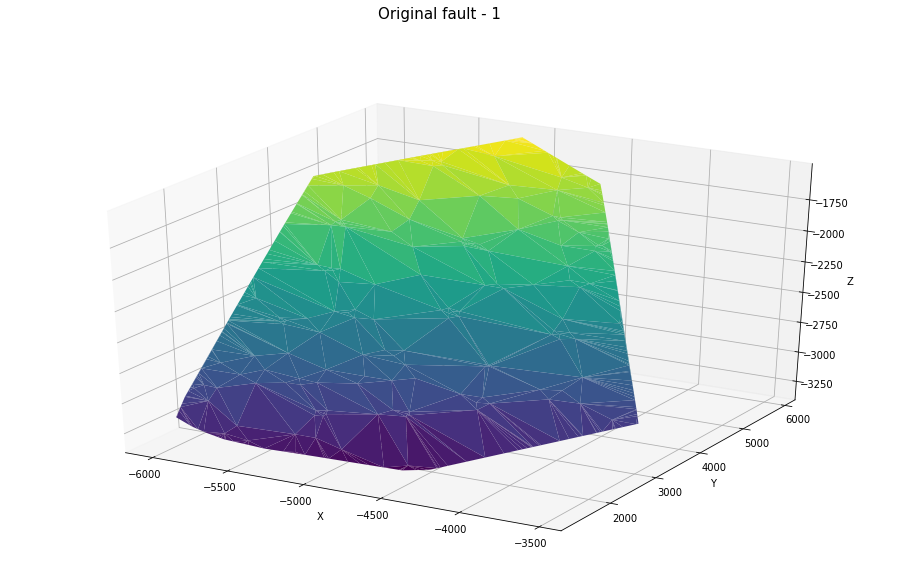

In [19]:
#%% Simple single fault visualization
import matplotlib.pyplot as plt
    
fault_ID = 1
fsp1 = np.array(fsp_dict[fault_ID])
X, Y, Z = fsp1[:, 2], fsp1[:, 3], fsp1[:, 4]

fig = plt.figure(figsize=(16,9))
title = 'Original fault - ' + str(fault_ID)
fig.suptitle(title,fontsize=15)
ax = fig.add_subplot(1, 1, 1, projection='3d')    
ax.plot_trisurf(X, Y, Z, cmap='viridis') # use triangular surface to plot xyz data
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('tight')
plt.show()


### 1.1 Strike-dip (Method 1)

Randomly select 3 points on the fault surface and calculate the strike and dip. Because the fault is not flat, therefore we do this 100 times and average the results. 

First, we adapt an algorithm to calculate the strike and dip from [here](https://github.com/tpubben/StructureCalculations/blob/master/strike_dip.py).



In [0]:
#%% Define function to calculate strik and dip, adapted from the link below
# The appropriate input for this function is a list of tuples in the format
# [(x1, y1, z1), (x2, y2, z2), (x3, y3, z3)]
#https://github.com/tpubben/StructureCalculations/blob/master/strike_dip.py

def calc_strikedip(pts):
    import math
    ptA, ptB, ptC = pts[0], pts[1], pts[2]
    x1, y1, z1 = float(ptA[0]), float(ptA[1]), float(ptA[2])
    x2, y2, z2 = float(ptB[0]), float(ptB[1]), float(ptB[2])
    x3, y3, z3 = float(ptC[0]), float(ptC[1]), float(ptC[2])


    u1 = float(((y1 - y2) * (z3 - z2) - (y3 - y2) * (z1 - z2)))
    u2 = float((-((x1 - x2) * (z3 - z2) - (x3 - x2) * (z1 - z2))))
    u3 = float(((x1 - x2) * (y3 - y2) - (x3 - x2) * (y1 - y2)))

    '''
    Calculate pseudo eastings and northings from origin
    these are actually coordinates of a new point that represents
    the normal from the plane's origin defined as (0,0,0).
    
    If the z value (u3) is above the plane we first reverse the easting
    then we check if the z value (u3) is below the plane, if so
    we reverse the northing. 
    
    This is to satisfy the right hand rule in geology where dip is always
    to the right if looking down strike. 
    '''
    if u3 < 0:
        easting = u2
    else:
        easting = -u2

    if u3 > 0:
        northing = u1
    else:
        northing = -u1
    
    if easting >= 0:
        partA_strike = math.pow(easting, 2) + math.pow(northing, 2)
        strike = math.degrees(math.acos(northing / math.sqrt(partA_strike)))
    else:
        partA_strike = northing / math.sqrt(math.pow(easting, 2) + math.pow(northing, 2))
        strike = math.degrees(2 * math.pi - math.acos(partA_strike))

    # determine dip
    # print(strike, 'strike')
    part1_dip = math.sqrt(math.pow(u2, 2) + math.pow(u1, 2))
    part2_dip = math.sqrt(math.pow(u1,2) + math.pow(u2,2) + math.pow(u3,2))
    dip = math.degrees(math.asin(part1_dip / part2_dip))

    return [strike, dip]

We create functions to randomly select 3 points of all surface points within a fault and calculate their average strike and dip

In [62]:
# function to randomly select 3 points
def rand_3P(FaultN):
  import random
  rand_3N = random.sample(range(len(FaultN)), k=3)

  pts = []
  for i in range(3):
    pts.append(tuple(FaultN.iloc[rand_3N[i],2:]))
  return pts

# function to calculate strike and dip 100 times

def cal_avg_strike_dip(FaultN):
  N = 1000
  strike_dip_temp = []
  for i in range(N):
    pts = rand_3P(FaultN)
    temp = calc_strikedip(pts)
    strike_dip_temp.append(temp)

  strike_dip_temp = pd.DataFrame(strike_dip_temp) 
  return  strike_dip_temp.mean(axis=0)

print('Strike and dip are:')
print(cal_avg_strike_dip(fsp_dict[1]))

Strike and dip are:
0    53.854124
1    29.389073
dtype: float64


### 1.2 Strike-dip Method 2

Instead of calculating strike and dip of random 3 points multiple times, we fit the uneven fault with a flat surface and choose first 3 surfact points to calculate the strike and dip. The result will be the same using any 3 points since the surface is flat.

We will use the fitted surface (flat or curved/quadratic) to find the fault intersection later so it's not inconvenient here to calculate strike/dip using fitted flat surface.


In [0]:

#%% Function to perform matrix calculation, AC = Z
#   A = [G, ones]

def calculate_A (G, order):    
    import itertools as it
    if order == 1:
               
        # linear plane
        A = np.concatenate((G, np.ones((G.shape[0],1))), axis=1)
        
    elif order == 2:
                        
        # quadratic plane
        dim = G.shape[1]
        A = np.concatenate((G**2, np.array([np.prod(G[:, k], axis=1) for k in it.combinations(range(dim), dim)]).transpose(), G, np.ones((G.shape[0], 1))), axis=1)
                        
    return A


def calculate_Z_ (A, C):    
              
    Z = np.dot(A, C.transpose()).reshape(A.shape[0])

    return Z

def calculate_C (A, Z):
    from scipy.linalg import  lstsq
    C, _, _, _ = lstsq(A, Z) 
    return C
    
    
#%% Create a function to fit a linear or quadratic surface/plane to the fault
# Adapted from https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

# Function to fit a surface to points

def fit_surface(X, Y, Z, order, mesh_num = 20):

    # regular grid covering the domain of the data
    X_,Y_ = np.meshgrid(np.linspace(min(X), max(X), mesh_num), np.linspace(min(Y), max(Y), mesh_num))

    XX = X_.flatten()
    YY = Y_.flatten()

    G = np.c_[X,Y]

    A = calculate_A (G, order=order)

    C = calculate_C (A, Z)
    Z_fitted = calculate_Z_(A, C)

    # meash Z_ for visualization plane
    if order == 1:
        Z_ = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X_.shape)
    elif order == 2:
        Z_ = np.dot(np.c_[XX**2, YY**2, XX*YY, XX, YY, np.ones(XX.shape)], C).reshape(X_.shape)

    return A, C, X_, Y_, Z_, Z_fitted  

First let's create a function to fit the fault with a flat surface (fitting order = 1) and return the points' (X, Y, Z_) coordinates from the corresponding original points' coordinates (X, Y, Z). 

Order = 1 means flat surfact and order = 2 means curved quadratic surface.

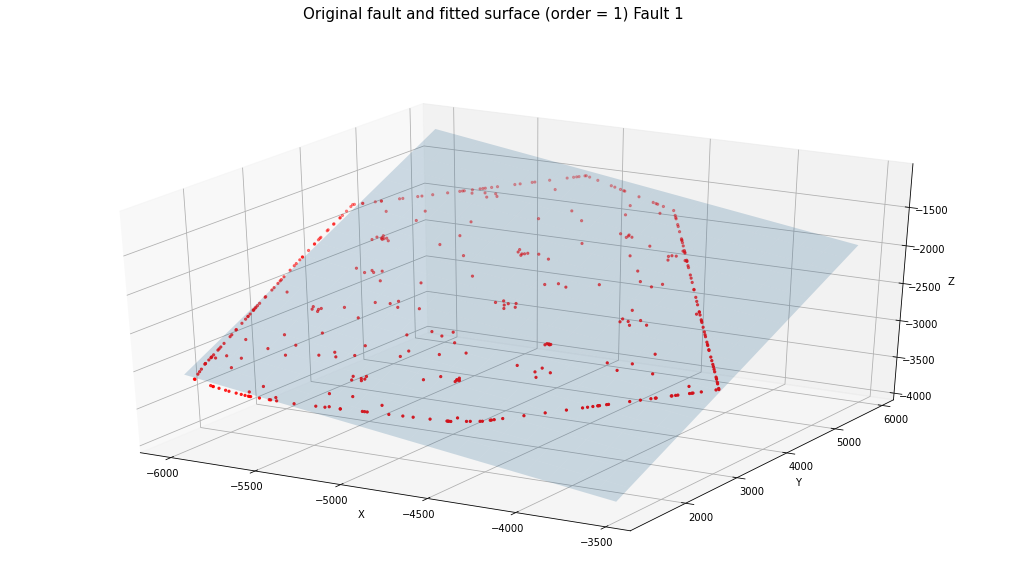

In [51]:
#%% Call function to fit the surface
order = 1
A, C, X_, Y_, Z_, Z_fitted = fit_surface(X, Y, Z, order)

#%% Plot the fault points and the fitted surface (linear or quadratic) in 3D

# plot points and fitted surface
fig = plt.figure(figsize=(18,9))
title = 'Original fault and fitted surface (order = ' + str(order) + ") " + 'Fault ' + str(fault_ID)
fig.suptitle(title,fontsize=15)
ax = fig.gca(projection='3d')
ax.plot_surface(X_, Y_, Z_, rstride=1, cstride=1, alpha=0.2)  #mesh grid
ax.scatter(X, Y, Z, c='r', s=5)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('tight')
plt.show()


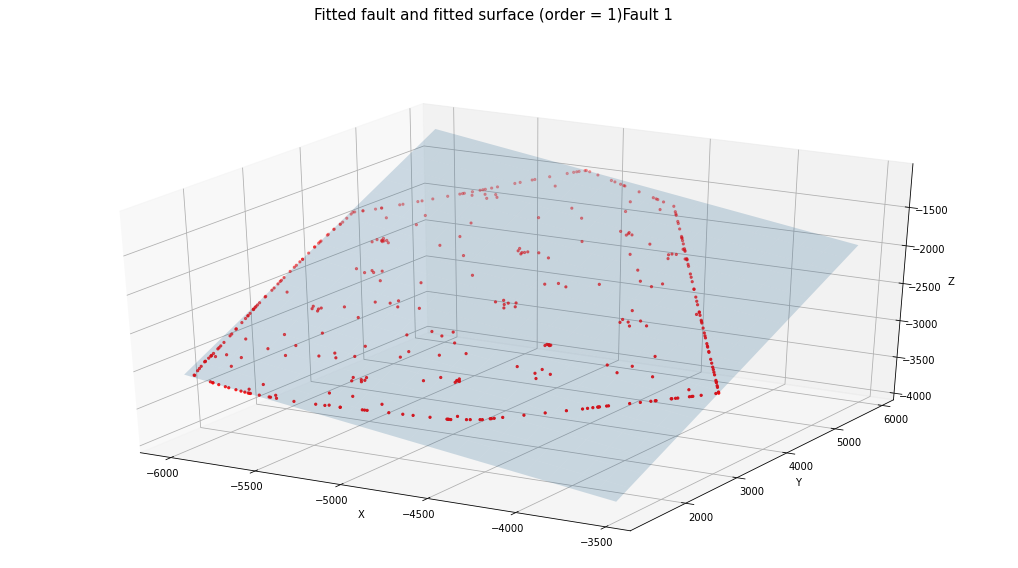

In [42]:
#%% Plot the new "fitted fault" 

# plot points and fitted surface
fig = plt.figure(figsize=(18,9))
title = 'Fitted fault and fitted surface (order = ' + str(order) + ")" + 'Fault ' + str(fault_ID)
fig.suptitle(title,fontsize=15)
ax = fig.gca(projection='3d')
ax.plot_surface(X_, Y_, Z_, rstride=1, cstride=1, alpha=0.2) #mesh grid
ax.scatter(X, Y, Z_fitted, c='r', s=5)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('tight')
plt.show()


The fitted surfact is flat and different from the original fault surface. You can observe the difference when rotating the fault in 3D interactive plot.

Now let's calculate strike and dip using method 2.


In [67]:
pts = np.c_[X, Y, Z_fitted][:3,:]
pts =[pts[0,:], pts[1,:], pts[2,:]]

strike_dip_f1 = calc_strikedip(pts)
print('Strike and dip are:')
print(strike_dip_f1)

Strike and dip are:
[51.885704355365306, 28.10946351984566]


The strike and dip from Method 2 is similar but not equal to from Method 1.

## 2. Fault max length

Here I will demonstrate how max fault length is calcualted 

Continue using *Fault 1* as an example. First let's find a polygon that encompasses the fault.


In [0]:
#%% Function to find a polygon

def find_polygon(X, Y, Z, order):  
    from scipy.spatial import ConvexHull
    A, C, X_, Y_, Z_, Z_fitted = fit_surface(X, Y, Z, order)

    points_XY = np.c_[X,Y]
    points_XYZ_ = np.c_[X,Y,Z_fitted]
    hull_2D = ConvexHull(points_XY)
    polygon_3D_linear = np.c_[points_XYZ_[hull_2D.vertices,0], points_XYZ_[hull_2D.vertices,1], points_XYZ_[hull_2D.vertices,2]]
    
    return polygon_3D_linear


Rotate the 3D linear plane so that the strike is parallel to X-axis

Text(0.5, 0, 'Z')

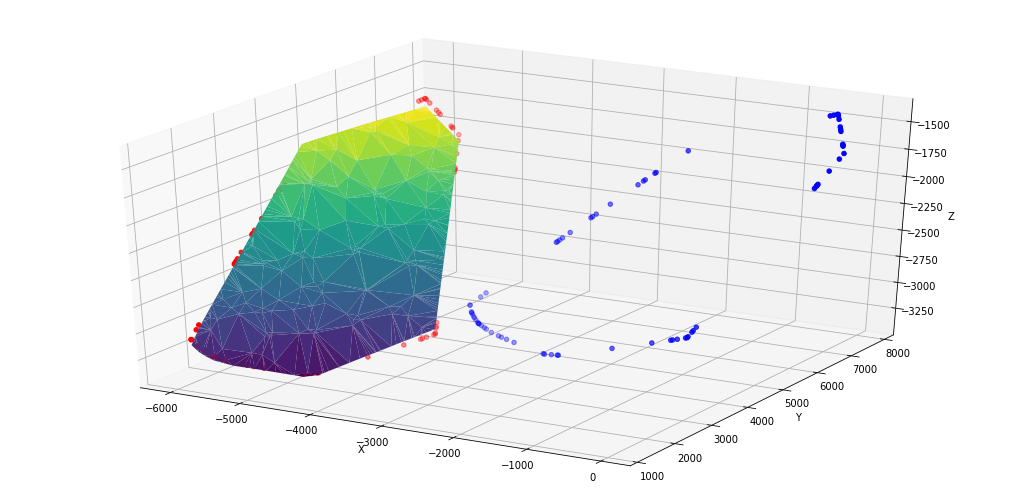

In [73]:
theta = np.radians(strike_dip_f1[0])
theta_d = np.degrees(theta)
rotation_matrix = np.array([[np.sin(theta), np.cos(theta)], [-np.cos(theta), np.sin(theta)]])

polygon_3D_linear = find_polygon(X, Y, Z, order)
polygon_2D = polygon_3D_linear[:,:-1]
XY_rotated = np.dot(rotation_matrix, polygon_2D.T).T
X_rotated, Y_rotated = XY_rotated[:,0], XY_rotated[:,1]

_, C, _, _, _, _ = fit_surface(X_rotated, Y_rotated, polygon_3D_linear[:,2], order)

# plt.close('all')
fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap='viridis')
ax.scatter(polygon_3D_linear[:,0],polygon_3D_linear[:,1], polygon_3D_linear[:,2], c='r', s=20)
ax.scatter(X_rotated, Y_rotated, polygon_3D_linear[:,2], c='b', s=20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


Now let's fill the entire polygon with a lot of points densely packed inside the fault. The maximum length of the fault is the line with max absolute value of (x1-x2). It's shown in red as below. 

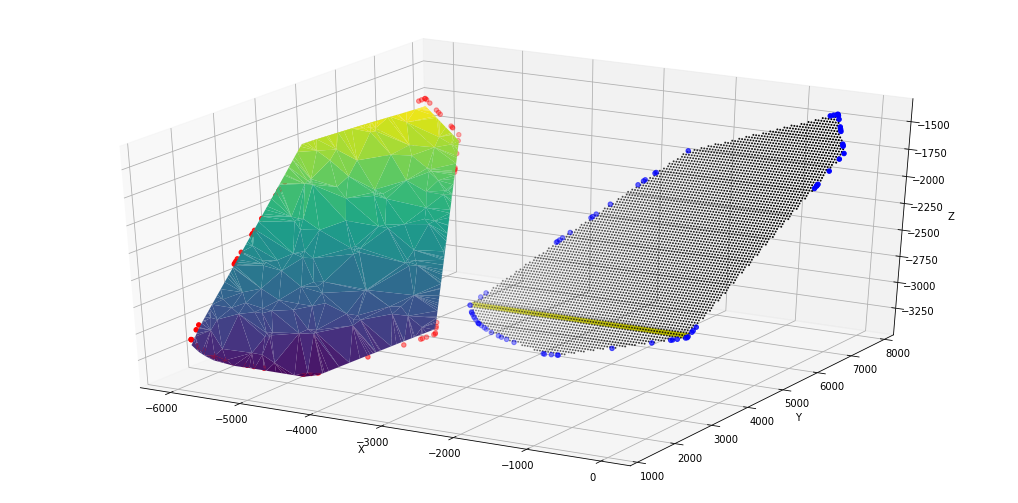

In [81]:
# Then fill with plane with dense points

# Get evenly distributed points inside a polygon
# Adapted from https://stackoverflow.com/questions/53091386/generating-evenly-spaced-points-on-grid-using-python

def even_points_within(poly, num_points):
    from shapely.geometry import Polygon, Point

    min_x, min_y, max_x, max_y = min(poly[:,0]),min(poly[:,1]),max(poly[:,0]),max(poly[:,1])
    x = (np.linspace(min_x,max_x,num_points))
    y=  (np.linspace(min_y,max_y,num_points))
    xx,yy = np.meshgrid(x,y,sparse=True)
    xx = xx.reshape((np.prod(xx.shape),))
    yy = yy.reshape((np.prod(yy.shape),))
    points = []

    poly = Polygon(poly)
    
    for y in yy:
        for x in xx:
           random_point = Point([x, y])
           if (random_point.within(poly)):
              points.append(list(random_point.coords))
              
    #print(min_x,max_x,max_y,min_y)
    return points


polygon_XY = np.c_[X_rotated, Y_rotated]
num_points=100

G = even_points_within(polygon_XY, num_points=num_points)
G = np.array([list(i[0]) for i in G ])
A = calculate_A (G, order)
Z_inside_= calculate_Z_(A, C)
polygon_surface_dense = np.c_[G,Z_inside_]

df_G = pd.DataFrame(G)
df_G.columns = ['X','Y']

max_length_ = []
for y in df_G.Y.unique():
    sel_x = df_G['X'][df_G['Y']==y]
    max_length_.append([y,max(sel_x)-min(sel_x)])

max_length_ = np.array(max_length_)

max_length = max(max_length_[:,1])
max_length_at_y = max_length_[:,0][max_length_[:,1]==max_length]
max_length_at_x = df_G['X'][df_G['Y']==max_length_at_y[0]]

max_length_line = np.array([max_length_at_x.values, [max_length_at_y[0]]*len(max_length_at_x)]).T

G = max_length_line
A = calculate_A (G, order)
Z_inside_= calculate_Z_(A, C)

# plot evenly selected points inside the polygon
# plt.close('all')
fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap='viridis')
ax.scatter(polygon_3D_linear[:,0],polygon_3D_linear[:,1], polygon_3D_linear[:,2], c='r', s=20)
ax.scatter(X_rotated, Y_rotated, polygon_3D_linear[:,2], c='b', s=20)
ax.scatter(polygon_surface_dense[:,0], polygon_surface_dense[:,1], polygon_surface_dense[:,2], c='k', s=1) 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot max length line
ax.scatter(max_length_line[:,0], max_length_line[:,1], Z_inside_, c='y', s=20) 

In [88]:
print('The max fault length is: ', int(max_length))

The max fault length is:  3016


## 3. Fault area

To calculate area of a fault, we divide the entire area into triangles, like what's shown with trisurf plot. We then calculate the area of each triangle and add the areas up.


In [108]:

#%% Create a function to calculate the area of the "fitted fault"
# Use Delaunay function from scipy package to divide the fitted surface to triangles
# https://plot.ly/python/v3/surface-triangulation/

# import chart_studio.plotly as py
# import plotly.graph_objects as go

import matplotlib.cm as cm
from scipy.spatial import Delaunay

#unit normal vector of plane defined by points a, b, and c
def unit_normal(a, b, c):
    x = np.linalg.det([[1,a[1],a[2]],
         [1,b[1],b[2]],
         [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
         [b[0],1,b[2]],
         [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
         [b[0],b[1],1],
         [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

#area of polygon poly
def poly_area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(poly)
    for i in range(N):
        vi1 = poly[i]
        vi2 = poly[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, unit_normal(poly[0], poly[1], poly[2]))
    return round((abs(result/2)),2)


# Calculate area based on trimesh surface (triangulate and compute all area of triangles)
fsp_key = 1
fsp = np.array(fsp_dict[fsp_key])
points2D=np.array(fsp[:,2:4])
tri=Delaunay(points2D) # Delaunay triangulation    
tri_area = 0
for i in range(tri.simplices.shape[0]):
    vertex_points = fsp[tri.simplices[i,:]][:,2:5] # 3 points in each triangle
    tri_area += poly_area(vertex_points) 

print('Fault 1 area is: ', tri_area)

Fault 1 area is:  8742850.11


## 4. Find fault intersection

The idea is:
1. Fit the two faults with quadratic surfaces, each surface is represented with a quadratic equation.
2. Use `sympy` package to solve these two quadratic equations and find the intersection

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


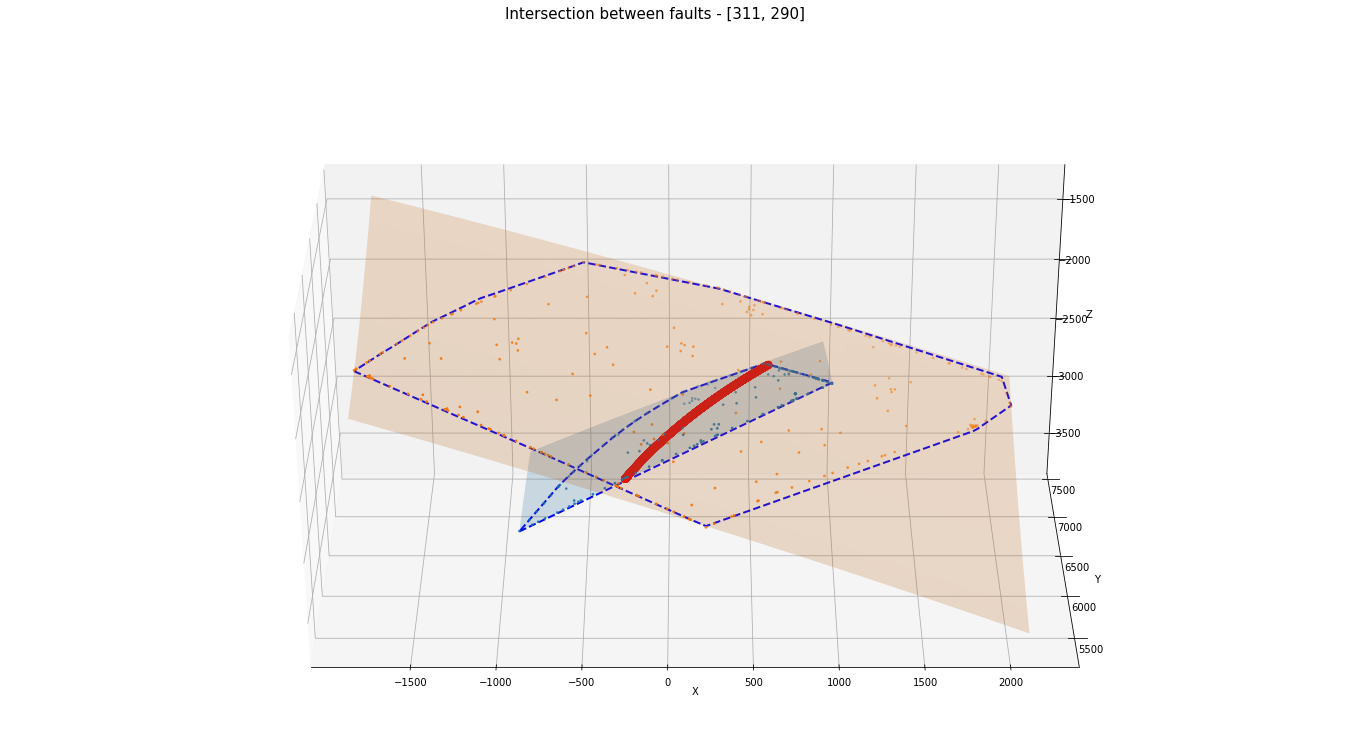

In [129]:

two_fault_keys = [311,290] 

fault_polygon = []
C_ = []

for fsp_key in two_fault_keys:
    fsp = np.array(fsp_dict[fsp_key])
    X, Y, Z = fsp[:, 2], fsp[:, 3], fsp[:, 4]
    order = 2
    A, C, X_, Y_, Z_, Z_fitted, polygon_3D_quadratic = fit_surface_find_polygon(X, Y, Z, order)
    fault_polygon.append(polygon_3D_quadratic)
    C_.append(C)

C_ = np.array(C_).T

# Fit the two faults with binary quadratic equations
# Find the intersection by solving these binary quadratic equations using "sym.solve"
# Adapted from: https://stackoverflow.com/questions/45130525/find-the-equation-y-yx-from-the-intersection-of-two-surfaces-z-zx-y

import sympy as sym
from numpy import sqrt
from shapely.geometry import Polygon, Point

a, b= C_[:,0], C_[:,1]
x, y = sym.symbols('x y', real=True)

def z_I(x,y):
        return   a[0]*x**2 + a[1]*y**2 + a[2]*x*y + a[3]*x + a[4]*y + a[5]

def z_II(x,y):
        return   b[0]*x**2 + b[1]*y**2 + b[2]*x*y + b[3]*x + b[4]*y + b[5]

# Find y from x
intersection_eq_y = sym.solve(z_I(x,y) - z_II(x,y), y)
# print ('Intersection equation =', intersection_eq_y)

x_min, x_max = min(X), max(X)
x_ = np.linspace(x_min, x_max, 10000)

x_y_ = np.empty((0,2), int)
for eq in intersection_eq_y:
    x = x_
    y_ = eval(str(eq))
    x_y_ = np.r_[x_y_, np.array([x_,y_]).T]

# Remove the invalid value encountered in sqrt
x_y_ = x_y_[~np.isnan(x_y_ [:,1])]

points = []

for i in range(len(x_y_)):
       point_ = Point([x_y_[i,0],x_y_[i,1]])
       poly_0 = Polygon(fault_polygon[0])
       poly_1 = Polygon(fault_polygon[1])
       if (point_.within(poly_0)) and (point_.within(poly_1)):
          points.append(list(point_.coords[0]))
points_y = np.array(points)

A = calculate_A(points_y, order)
z_ = calculate_Z_ (A, C)
points_xy = np.c_[points_y, z_]

# Plot the intersection line
fig = plt.figure(figsize=(24,12))
title = 'Intersection between faults - ' + str(two_fault_keys)
fig.suptitle(title,fontsize=15)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for fsp_key in two_fault_keys:
    fsp = np.array(fsp_dict[fsp_key])

    X, Y, Z = fsp[:, 2], fsp[:, 3], fsp[:, 4]
    A, C, X_, Y_, Z_, Z_fitted = fit_surface(X, Y, Z, order, mesh_num = 20)

    ax.scatter(X, Y, Z, cmap='viridis', s=3)
    ax.scatter(points_xy[:,0], points_xy[:,1], points_xy[:,2], c='r', s=50)
    ax.plot_surface(X_, Y_, Z_, rstride=1, cstride=1, alpha=0.2)  #mesh grid

# Plot the 'approximate' boundary of the faults for better visualization of the faults
# This boundary "looks good" if the faults are convex shape, "look not so good"
# if the faults are concave shape. Again, this is for visualization only!

for poly_bound in fault_polygon:
    poly_bound = np.r_[poly_bound, poly_bound[0,:].reshape(1,-1)]
    ax.plot(poly_bound[:,0], poly_bound[:,1], poly_bound[:,2], 'b--', lw=2) # plot bounding polygon

ax.view_init(elev=30, azim=-90)
# plt.savefig(title + '.png')
plt.show()